In [2]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from torchvision import transforms
import torchvision
import torch.optim as optim
import tensorflow
import keras
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch.utils.tensorboard import SummaryWriter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
# Load data
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers

    df_list = []
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_list.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        })
    df_ = pd.DataFrame(df_list)
    return df_

# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, val_data, training_labels, val_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.30,
    random_state=0,
    shuffle=True
)

validation_data, test_data, validation_labels, test_labels = train_test_split(val_data, val_labels,test_size=0.50, random_state=0, shuffle=True)


# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
test_data = word_vectorizer.transform(test_data)
test_data = test_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()
test_x_tensor = torch.from_numpy(np.array(test_data)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(test_labels)).long()

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 32

# Create DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [71]:
class Chatbot(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,output_size,dropout=0.2):
        super(Chatbot,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size,out_features=output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x = x.unsqueeze(1)
        out, _ = self.lstm(x, (h0, c0))  # Forward pass through LSTM
        out = self.fc(out[:, -1, :])  # Take the last output and pass it through a linear layer
        out = self.sigmoid(out)  # Apply sigmoid activation
        return out

class ChatbotSimple(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ChatbotSimple, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded_avg = torch.mean(embedded, dim=1)  # Average pooling over the sequence dimension
        output = self.fc(embedded_avg)
        return output



class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.2):
        super().__init__()
        self.model_type = 'Transformer'

        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        # Transpose the input tensor to the correct shape
        src = src.transpose(0, 1)

        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = self.pos_encoder(src)
        if src_mask is None:
            seq_len = src.size(0)
            src_mask = torch.triu(torch.ones(seq_len, seq_len, device=src.device), diagonal=1)
            src_mask = src_mask.masked_fill(src_mask == 1, float('-inf'))
        output = self.transformer_encoder(src, src_mask)

        output = output.transpose(0, 1)

        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        pe = self.pe[:x.size(0), :].unsqueeze(1)
        x = x + pe
        return self.dropout(x)

In [7]:
# Train model
def train_model(model,criterion,optimizer,num_epochs,train_loader,validation_loader,device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_sd = None
    model.to(device)
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode

        for inputs,labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()  # Zero the gradients
          outputs = model(inputs)  # Forward pass
          loss = criterion(outputs,labels)  # Calculate the loss
          loss.backward()  # Backward pass
          optimizer.step()  # Update weights

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in validation_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)  # Forward pass
              val_loss = criterion(outputs, labels)  # Calculate the loss


        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_sd = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_sd)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    return model


In [68]:
# Train model
def train_tr_model(model,criterion,optimizer,num_epochs,train_loader,validation_loader,device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_sd = None
    model.to(device)
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode

        for inputs,labels in train_loader:
          inputs = inputs.to(device)
          inputs = inputs.to_dense()
          inputs = inputs.transpose(0, 1)
          inputs = inputs.long()
          labels = labels.to(device)
          optimizer.zero_grad()  # Zero the gradients
          outputs = model(inputs)  # Forward pass
          loss = criterion(outputs,labels)  # Calculate the loss
          loss.backward()  # Backward pass
          optimizer.step()  # Update weights

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in validation_loader:
              inputs = inputs.to(device)
              inputs = inputs.to_dense()
              inputs = inputs.transpose(0, 1)
              inputs = inputs.long()
              labels = labels.to(device)
              outputs = model(inputs)  # Forward pass
              val_loss = criterion(outputs, labels)  # Calculate the loss


        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_sd = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_sd)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    return model

In [24]:
# Test model
def test_model(model, test_loader,device):
    classes = ['positive', 'negative']

    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.to(device)
    model.eval()

    for inputs,labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print(f'Test accuracy of the network: {100 * correct // total} %')
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch 10/500, Training Loss: 0.6831, Validation Loss: 0.6890
Epoch 20/500, Training Loss: 0.4626, Validation Loss: 0.5721
Epoch 30/500, Training Loss: 0.3359, Validation Loss: 0.4752
Epoch 40/500, Training Loss: 0.3545, Validation Loss: 0.4564
Epoch 50/500, Training Loss: 0.3183, Validation Loss: 0.4505
Epoch 60/500, Training Loss: 0.3142, Validation Loss: 0.4486
Epoch 70/500, Training Loss: 0.3150, Validation Loss: 0.4477
Epoch 80/500, Training Loss: 0.3140, Validation Loss: 0.4498
Epoch 90/500, Training Loss: 0.3137, Validation Loss: 0.4504
Epoch 100/500, Training Loss: 0.3137, Validation Loss: 0.4554
Epoch 110/500, Training Loss: 0.3134, Validation Loss: 0.4561
Epoch 120/500, Training Loss: 0.3136, Validation Loss: 0.4588
Epoch 130/500, Training Loss: 0.3227, Validation Loss: 0.4522
Epoch 140/500, Training Loss: 0.3137, Validation Loss: 0.4513
Epoch 150/500, Training Loss: 0.3134, Validation Loss: 0.4578
Epoch 160/500, Training Loss: 0.3135, Validation Loss: 0.4567
Epoch 170/500, Tr

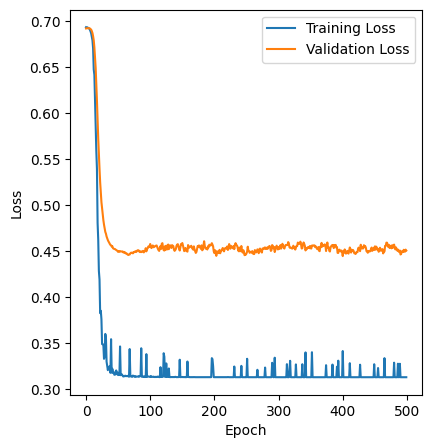

In [14]:
epochs = 500
input_size = 4114  # Size of vocabulary
hidden_size = 256  # Size of hidden layer
output_size = 2  # Size of vocabulary (for response)
num_layers = 2

model = Chatbot(input_size=input_size, hidden_size=hidden_size, output_size=output_size,num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

trained_model_lstm = train_model(model=model,criterion=criterion,optimizer=optimizer,train_loader=train_loader,validation_loader=validation_loader,num_epochs=epochs,device=device)


Epoch 10/500, Training Loss: 0.7114, Validation Loss: 0.7021
Epoch 20/500, Training Loss: 0.6935, Validation Loss: 0.7024
Epoch 30/500, Training Loss: 0.6934, Validation Loss: 0.6964
Epoch 40/500, Training Loss: 0.6889, Validation Loss: 0.7021
Epoch 50/500, Training Loss: 0.6917, Validation Loss: 0.7003
Epoch 60/500, Training Loss: 0.6912, Validation Loss: 0.7042
Epoch 70/500, Training Loss: 0.6973, Validation Loss: 0.7003
Epoch 80/500, Training Loss: 0.6933, Validation Loss: 0.6946
Epoch 90/500, Training Loss: 0.6903, Validation Loss: 0.6998
Epoch 100/500, Training Loss: 0.6915, Validation Loss: 0.7014
Epoch 110/500, Training Loss: 0.6941, Validation Loss: 0.6965
Epoch 120/500, Training Loss: 0.6939, Validation Loss: 0.6921
Epoch 130/500, Training Loss: 0.6933, Validation Loss: 0.6989
Epoch 140/500, Training Loss: 0.6858, Validation Loss: 0.7010
Epoch 150/500, Training Loss: 0.6843, Validation Loss: 0.7068
Epoch 160/500, Training Loss: 0.6926, Validation Loss: 0.6919
Epoch 170/500, Tr

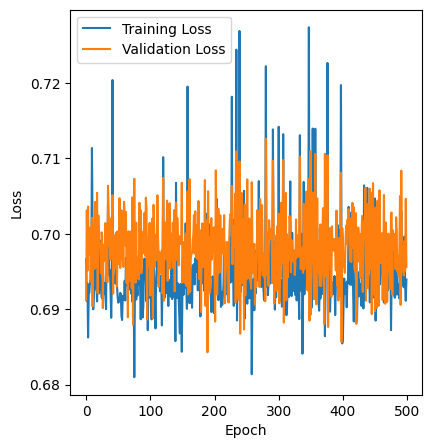

In [15]:
epochs = 500
input_size = 4114  # Size of vocabulary
hidden_size = 256  # Size of hidden layer
output_size = 2  # Size of vocabulary (for response)
num_layers = 2

model = ChatbotSimple(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

train_x_tensor_bot = torch.from_numpy(np.array(training_data)).long()
train_y_tensor_bot = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor_bot = torch.from_numpy(np.array(validation_data)).long()
validation_y_tensor_bot = torch.from_numpy(np.array(validation_labels)).long()
test_x_tensor_bot = torch.from_numpy(np.array(test_data)).long()
test_y_tensor_bot = torch.from_numpy(np.array(test_labels)).long()

train_dataset_bot = TensorDataset(train_x_tensor_bot, train_y_tensor_bot)
validation_dataset_bot = TensorDataset(validation_x_tensor_bot, validation_y_tensor_bot)
test_dataset_bot = TensorDataset(test_x_tensor_bot, test_y_tensor_bot)

train_loader_bot = DataLoader(train_dataset_bot, batch_size=batch_size, shuffle=True)
validation_loader_bot = DataLoader(validation_dataset_bot, batch_size=batch_size)
test_loader_bot = DataLoader(test_dataset_bot, batch_size=batch_size)

trained_model_emb = train_model(model=model,criterion=criterion,optimizer=optimizer,train_loader=train_loader_bot,validation_loader=validation_loader_bot,num_epochs=epochs,device=device)


In [72]:
epochs = 100
ntokens = 4114  # size of vocabulary
emsize = 10  # embedding dimension
d_hid = 10  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 1  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# vectorize data using TFIDF and transform for PyTorch for scalability
training_data, val_data, training_labels, val_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.30,
    random_state=0,
    shuffle=True
)

validation_data, test_data, validation_labels, test_labels = train_test_split(val_data, val_labels,test_size=0.50, random_state=0, shuffle=True)
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
test_data = word_vectorizer.transform(test_data)
test_data = test_data.todense()

# Convert data to PyTorch tensors
train_x_tensor_tr = torch.tensor(training_data, dtype=torch.float32)
train_y_tensor_tr = torch.tensor(training_labels, dtype=torch.long)
validation_x_tensor_tr = torch.tensor(validation_data, dtype=torch.float32)
validation_y_tensor_tr = torch.tensor(validation_labels, dtype=torch.long)
test_x_tensor_tr = torch.tensor(test_data, dtype=torch.float32)
test_y_tensor_tr = torch.tensor(test_labels, dtype=torch.long)

# Create datasets and dataloaders
train_dataset_tr = TensorDataset(train_x_tensor_tr, train_y_tensor_tr)
validation_dataset_tr = TensorDataset(validation_x_tensor_tr, validation_y_tensor_tr)
test_dataset_tr = TensorDataset(test_x_tensor_tr, test_y_tensor_tr)

batch_size = 32

# Create DataLoader for training, validation, and test datasets
train_loader_tr = DataLoader(train_dataset_tr, batch_size=batch_size, shuffle=True)
validation_loader_tr = DataLoader(validation_dataset_tr, batch_size=batch_size)
test_loader_tr = DataLoader(test_dataset_tr, batch_size=batch_size)

trained_model_trans = train_tr_model(model=model,criterion=criterion,optimizer=optimizer,train_loader=train_loader_tr,validation_loader=validation_loader_tr,num_epochs=epochs,device=device)

AssertionError: query should be unbatched 2D or batched 3D tensor but received 4-D query tensor

Test accuracy of the network: 80 %


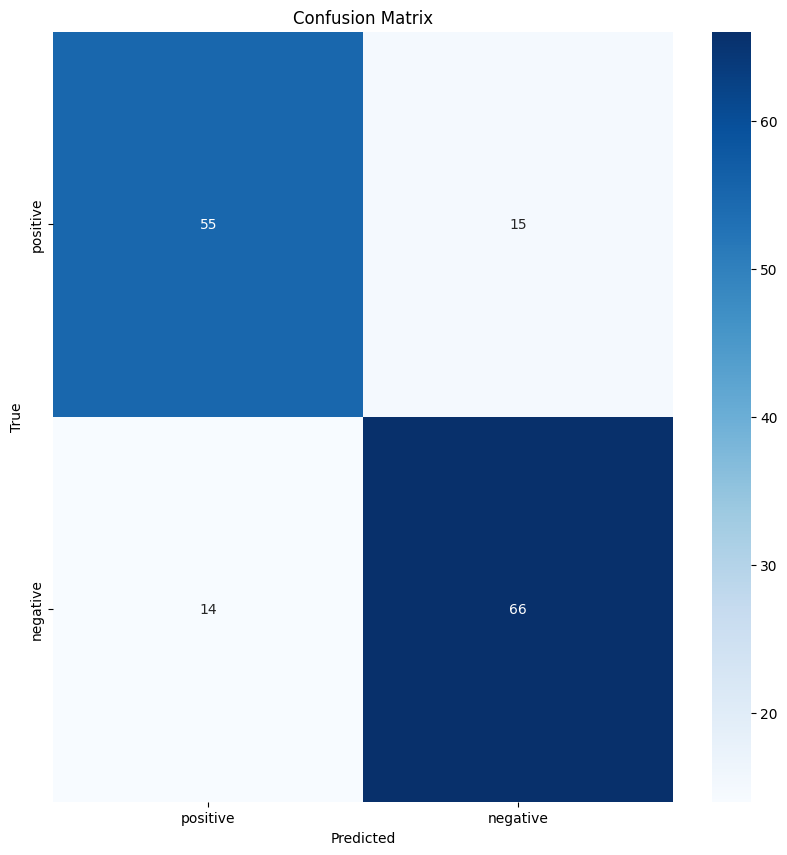

In [25]:
# Test models
test_model(trained_model_lstm,test_loader=test_loader,device=device)

Test accuracy of the network: 53 %


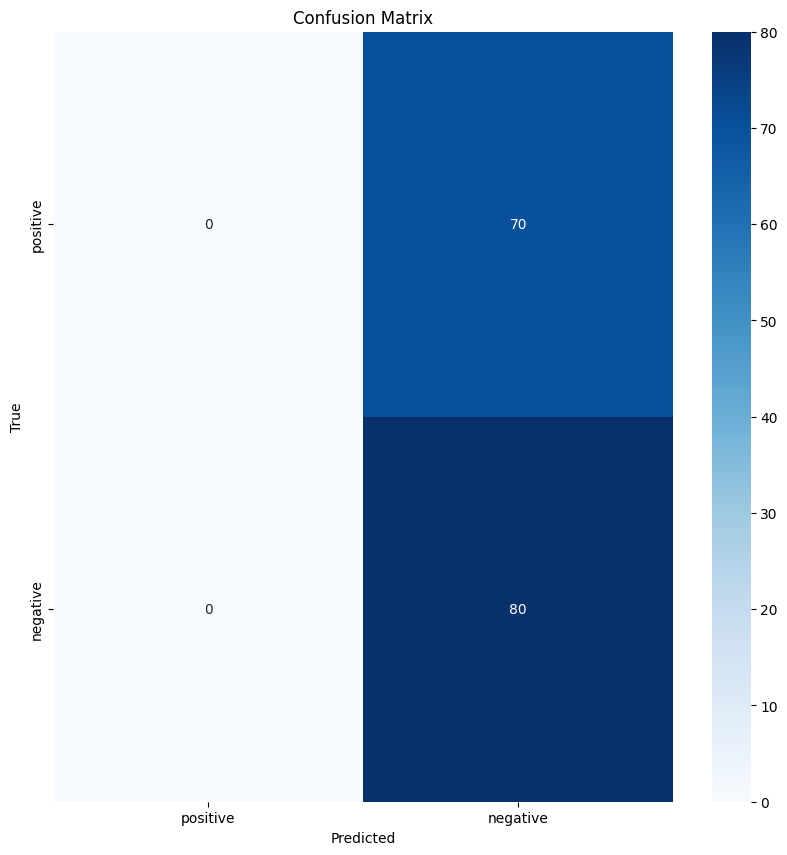

In [26]:
test_model(trained_model_emb,test_loader=test_loader_bot,device=device)

In [ ]:
test_model(trained_model_trans)

In [ ]:
def analyze_sentiment(text):

    text = word_vectorizer.transform([text])
    text = text.todense()                             # convert to dense matrix for Pytorch
    text_tensor_ltsm = torch.from_numpy(np.array(text)).type(torch.FloatTensor)
    text_tensor_emb = torch.from_numpy(np.array(text)).type(torch.FloatTensor).long()
    with torch.no_grad():
        output = trained_model_emb(text_tensor_emb)
        _, predicted = torch.max(output.data, 1)
        sentiment1 = "positive" if predicted.item() == 1 else "negative"

    with torch.no_grad():
        output = trained_model_lstm(text_tensor_ltsm)
        _, predicted = torch.max(output.data, 1)
        sentiment2= "positive" if predicted.item() == 1 else "negative"

    return  sentiment2

In [ ]:
print("Welcome to the Sentiment Analysis Chatbot!")
#while True:
user_input = input("Please enter your review: ")
if user_input.lower() == "exit" or user_input == "":
    print("Exiting the chatbot.")
    #break
else:
    sentiment = analyze_sentiment(user_input)
    print(f"The sentiment of your review is {sentiment}.")